# Finetune Stable Diffusion and generate images with Intel Gaudi

<a id="try-anyscale-quickstart-intel_gaudi-sd" href="https://console.anyscale.com/register/ha?render_flow=ray&utm_source=ray_docs&utm_medium=docs&utm_campaign=intel_gaudi-sd">
    <img src="../../../_static/img/run-on-anyscale.svg" alt="try-anyscale-quickstart">
</a>
<br></br>

In this tutorial, we will go through how to finetune a stable diffusion model and generate images with Intel Gaudi(HPU). Moreover, we will show how to adapt an existing HPU example to use Ray. Once you learned how to make the adaption, you can easily access more models and optimizations that has been developed for HPU by "Ray-ifying" examples from [optimum-habana/examples](https://github.com/huggingface/optimum-habana/tree/main/examples) and [Model References](https://github.com/HabanaAI/Model-References)!

Now, let's see how we can "Ray-ify" this [stable diffusion example](https://github.com/huggingface/optimum-habana/tree/main/examples/stable-diffusion)

## Configuration
A node with Gaudi/Gaudi2 installed is required to run this example. Both Gaudi and Gaudi2 have 8 HPUs.

We recommend using a prebuilt container to run these examples. To run a container, you need Docker. See [Install Docker Engine](https://docs.docker.com/engine/install/) for installation instructions.

Next, follow [Run Using Containers](https://docs.habana.ai/en/latest/Installation_Guide/Bare_Metal_Fresh_OS.html?highlight=installer#run-using-containers) to install the Gaudi drivers and container runtime.

Then, start the Gaudi container:
```bash
docker pull vault.habana.ai/gaudi-docker/1.22.1/ubuntu24.04/habanalabs/pytorch-installer-2.7.1:latest
docker run -it --runtime=habana -e HABANA_VISIBLE_DEVICES=all -e OMPI_MCA_btl_vader_single_copy_mechanism=none --cap-add=sys_nice --net=host --ipc=host vault.habana.ai/gaudi-docker/1.22.1/ubuntu24.04/habanalabs/pytorch-installer-2.7.1:latest
```

Inside the container, clone [Optimum-Habana](https://github.com/huggingface/optimum-habana/) and install the dependencies:
```bash
git clone --branch v1.19.1 https://github.com/huggingface/optimum-habana.git
pip install ray[train,serve] optimum-habana
cd optimum-habana/
pip install -r examples/stable-diffusion/requirements.txt
pip install -r examples/stable-diffusion/training/requirements.txt
```

## Fine-tuning with Textual Inversion
First, let's start with fine-tuning. Check `examples/stable-diffusion/training/textual_inversion_sdxl.py` which fine-tunes a Stable Diffusion model on HPU. You can follow [this document](https://github.com/huggingface/optimum-habana/blob/main/examples/stable-diffusion/training/README.md#textual-inversion-xl) and try it once without using Ray.

In order to run this script on Ray, we need to make some changes. But don't worry, it's actually pretty simple. Basically, we just need to identify the main training loop, and run it in TorchTrainer.

First, check this block at the end of the file:
```python
if __name__ == "__main__":
    main()
```

Originally, this script will be started by MPI if multiple workers are used. But with Ray, we should setup TorchTrainer and supply a main function, which is `main()` in this example.

Therefore, it becomes straight-forward to make these changes:
```python
if __name__ == "__main__":
    import ray
    from ray import train
    from ray.train import ScalingConfig, Checkpoint, CheckpointConfig, RunConfig
    from ray.train.torch import TorchTrainer, TorchConfig

    # Workaround https://github.com/ray-project/ray/issues/45302 by explictly setting HPU resource
    ray.init(resources={"HPU": 8})

    # Configure computation resources
    # In ScalingConfig, require an HPU for each worker
    scaling_config = ScalingConfig(num_workers=1, resources_per_worker={"CPU": 1, "HPU": 1})
    # Set backend to hccl in TorchConfig
    torch_config = TorchConfig(backend = "hccl")
    # Initialize a Ray TorchTrainer
    trainer = TorchTrainer(
        train_loop_per_worker=main,
        torch_config=torch_config,
        scaling_config=scaling_config,
    )

    result = trainer.fit()
```

Before we try to run, we need to inspect the `main` function to see if it can work in such way. As we skim through the function, it's clear that it does not take any input parameters, but it calls `parse_args` to get all configurations. Originally, these configurations are set in command line by MPI. But because we switch to Ray to start the workers, command line arguments are no longer accessible. Therefore, `parse_args` should be called in the main program and passed to `main` function.

Apart from this, no other changes are necessary. By inserting the following code, you can now run the script on Ray.

In [ ]:
# Replace lines below:
# def main():
#     args = parse_args()
# with these lines:
def main(config):
    args = config["args"]

In [ ]:
# Replace lines below:
# if __name__ == "__main__":
#     main()
# with these lines:
if __name__ == "__main__":
    import ray
    from ray import train
    from ray.train import ScalingConfig, Checkpoint, CheckpointConfig, RunConfig
    from ray.train.torch import TorchTrainer, TorchConfig

    # Workaround https://github.com/ray-project/ray/issues/45302 by explictly setting HPU resource
    ray.init(resources={"HPU": 8})

    # Configure computation resources
    # In ScalingConfig, require an HPU for each worker
    scaling_config = ScalingConfig(num_workers=1, resources_per_worker={"CPU": 1, "HPU": 1})
    # Set backend to hccl in TorchConfig
    torch_config = TorchConfig(backend = "hccl")
    # Initialize a Ray TorchTrainer
    trainer = TorchTrainer(
        train_loop_per_worker=main,
        train_loop_config={"args": parse_args()},
        torch_config=torch_config,
        scaling_config=scaling_config,
    )

    result = trainer.fit()

One last thing: remember to use absolute path in the command line arguments. The reason is similar to why we move `parse_args` out, Ray's workers do not share the current working directory. Now, you can run the fine-tuning of Stable Diffusion on Ray!

First, download the training dataset of cat toy images from https://huggingface.co/datasets/diffusers/cat_toy_example if not already present.
```bash
python /optimum-habana/examples/stable-diffusion/training/download_train_datasets.py
```

An example command:
```bash
PT_HPU_LAZY_MODE=1 python /optimum-habana/examples/stable-diffusion/training/textual_inversion_sdxl.py \
    --pretrained_model_name_or_path stabilityai/stable-diffusion-xl-base-1.0 \
    --train_data_dir /optimum-habana/cat \
    --learnable_property object \
    --placeholder_token "<cat-toy>" \
    --initializer_token toy \
    --resolution 768 \
    --train_batch_size 1 \
    --gradient_accumulation_steps 4 \
    --max_train_steps 500 \
    --learning_rate 5.0e-04 \
    --scale_lr \
    --lr_scheduler constant \
    --lr_warmup_steps 0 \
    --output_dir /tmp/textual_inversion_cat_sdxl \
    --save_as_full_pipeline \
    --gaudi_config_name Habana/stable-diffusion \
    --sdp_on_bf16 \
    --throughput_warmup_steps 3
```

The output of the example command:
``` text
Multiple distributions found for package optimum. Picked distribution: optimum-habana
Initializing conditional components...
Using HPU fused kernel for apply_rotary_pos_emb
Using HPU fused kernel for RMSNorm
Using HPU fused kernel for apply_rotary_pos_emb
Using HPU fused kernel for RMSNorm
2025-11-19 19:53:48,664 INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265
/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(TrainController pid=285789) Attempting to start training worker group of size 1 with the following resources: [{'CPU': 1, 'HPU': 1}] * 1
(RayTrainWorker pid=286203) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=286203) PyTorch version 2.7.1+hpu.1.22.1.6.git6dbe0a4 available.
(RayTrainWorker pid=286203) Multiple distributions found for package optimum. Picked distribution: optimum-habana
(RayTrainWorker pid=286203) Initializing conditional components...
(RayTrainWorker pid=286203) Using HPU fused kernel for apply_rotary_pos_emb
(RayTrainWorker pid=286203) Using HPU fused kernel for RMSNorm
(RayTrainWorker pid=286203) Using HPU fused kernel for apply_rotary_pos_emb
(RayTrainWorker pid=286203) Using HPU fused kernel for RMSNorm
(TrainController pid=285789) Started training worker group of size 1:
(TrainController pid=285789) - (ip=100.83.67.100, pid=286203) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=286203) /usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=286203)   warnings.warn(
(RayTrainWorker pid=286203) Distributed environment: DistributedType.MULTI_HPU  Backend: hccl
(RayTrainWorker pid=286203) Num processes: 1
(RayTrainWorker pid=286203) Process index: 0
(RayTrainWorker pid=286203) Local process index: 0
(RayTrainWorker pid=286203) Device: hpu
(RayTrainWorker pid=286203)
(RayTrainWorker pid=286203) Mixed precision type: bf16
(RayTrainWorker pid=286203)
(RayTrainWorker pid=286203) [INFO|configuration_utils.py:243] 2025-11-19 19:54:15,626 >> loading configuration file gaudi_config.json from cache at /root/.cache/huggingface/hub/models--Habana--stable-diffusion/snapshots/60ee357057ec90d2b183de22d0327ddd5d5a6db9/gaudi_config.json
(RayTrainWorker pid=286203) [INFO|configuration_utils.py:296] 2025-11-19 19:54:15,626 >> GaudiConfig {
(RayTrainWorker pid=286203)   "autocast_bf16_ops": null,
(RayTrainWorker pid=286203)   "autocast_fp32_ops": null,
(RayTrainWorker pid=286203)   "optimum_version": "2.0.0",
(RayTrainWorker pid=286203)   "transformers_version": "4.51.3",
(RayTrainWorker pid=286203)   "use_dynamic_shapes": false,
(RayTrainWorker pid=286203)   "use_fused_adam": true,
(RayTrainWorker pid=286203)   "use_fused_clip_norm": true,
(RayTrainWorker pid=286203)   "use_torch_autocast": true
(RayTrainWorker pid=286203) }
(RayTrainWorker pid=286203)
(RayTrainWorker pid=286203) {'use_habana', 'use_hpu_graphs', 'bf16_full_eval', 'feature_extractor', 'sdp_on_bf16', 'gaudi_config', 'image_encoder'} was not found in config. Values will be initialized to default values.
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]{'mid_block_add_attention', 'latents_mean', 'use_post_quant_conv', 'shift_factor', 'latents_std', 'use_quant_conv'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=286203) All model checkpoint weights were used when initializing AutoencoderKL.
(RayTrainWorker pid=286203)
(RayTrainWorker pid=286203) All the weights of AutoencoderKL were initialized from the model checkpoint at /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/462165984030d82259a11f4367a4eed129e94a7b/vae.
(RayTrainWorker pid=286203) If your task is similar to the task the model of the checkpoint was trained on, you can already use AutoencoderKL for predictions without further training.
(RayTrainWorker pid=286203) Loaded vae as AutoencoderKL from `vae` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
(RayTrainWorker pid=286203) Loaded tokenizer_2 as CLIPTokenizer from `tokenizer_2` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00, 19.16it/s]Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
(RayTrainWorker pid=286203) {'reverse_transformer_layers_per_block', 'dropout', 'attention_type'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=286203) All model checkpoint weights were used when initializing UNet2DConditionModel.
(RayTrainWorker pid=286203)
(RayTrainWorker pid=286203) All the weights of UNet2DConditionModel were initialized from the model checkpoint at /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/462165984030d82259a11f4367a4eed129e94a7b/unet.
(RayTrainWorker pid=286203) If your task is similar to the task the model of the checkpoint was trained on, you can already use UNet2DConditionModel for predictions without further training.
(RayTrainWorker pid=286203) Loaded unet as UNet2DConditionModel from `unet` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loading pipeline components...:  57%|█████▋    | 4/7 [00:00<00:00,  7.38it/s]
(RayTrainWorker pid=286203) Loaded text_encoder_2 as CLIPTextModelWithProjection from `text_encoder_2` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
(RayTrainWorker pid=286203) {'use_exponential_sigmas', 'sigma_max', 'rescale_betas_zero_snr', 'use_beta_sigmas', 'final_sigmas_type', 'sigma_min', 'timestep_type'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=286203) Loaded scheduler as EulerDiscreteScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:00<00:00,  9.28it/s]Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.05it/s]
(RayTrainWorker pid=286203) [INFO|pipeline_utils.py:138] 2025-11-19 19:54:16,495 >> Enabled HPU graphs.
(RayTrainWorker pid=286203) ============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
(RayTrainWorker pid=286203)  PT_HPU_LAZY_MODE = 1
(RayTrainWorker pid=286203)  PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
(RayTrainWorker pid=286203)  PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
(RayTrainWorker pid=286203)  PT_HPU_LAZY_ACC_PAR_MODE = 1
(RayTrainWorker pid=286203)  PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
(RayTrainWorker pid=286203)  PT_HPU_EAGER_PIPELINE_ENABLE = 1
(RayTrainWorker pid=286203)  PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
(RayTrainWorker pid=286203)  PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
(RayTrainWorker pid=286203) ---------------------------: System Configuration :---------------------------
(RayTrainWorker pid=286203) Num CPU Cores : 160
(RayTrainWorker pid=286203) CPU RAM       : 1007 GB
(RayTrainWorker pid=286203) ------------------------------------------------------------------------------
(RayTrainWorker pid=286203) {'rescale_betas_zero_snr', 'variance_type', 'dynamic_thresholding_ratio', 'clip_sample_range', 'thresholding'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=286203) The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
(RayTrainWorker pid=286203) ***** Running training *****
(RayTrainWorker pid=286203)   Num examples = 600
(RayTrainWorker pid=286203)   Num Epochs = 4
(RayTrainWorker pid=286203)   Instantaneous batch size per device = 1
(RayTrainWorker pid=286203)   Total train batch size (w. parallel, distributed & accumulation) = 4
(RayTrainWorker pid=286203)   Gradient Accumulation steps = 4
(RayTrainWorker pid=286203)   Total optimization steps = 500
Steps:   0%|          | 0/500 [00:00<?, ?it/s]
(RayTrainWorker pid=286203) /usr/local/lib/python3.12/dist-packages/diffusers/models/unets/unet_2d_blocks.py:1351: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
(RayTrainWorker pid=286203)   deprecate("scale", "1.0.0", deprecation_message)
(RayTrainWorker pid=286203) /usr/local/lib/python3.12/dist-packages/diffusers/models/unets/unet_2d_blocks.py:2535: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
(RayTrainWorker pid=286203)   deprecate("scale", "1.0.0", deprecation_message)
Steps:   0%|          | 0/500 [01:12<?, ?it/s, loss=0.176, lr=0.002]
Steps:   0%|          | 0/500 [02:18<?, ?it/s, loss=0.118, lr=0.002]
Steps:   0%|          | 0/500 [02:19<?, ?it/s, loss=0.00333, lr=0.002]
Steps:   0%|          | 1/500 [02:20<19:27:52, 140.43s/it, loss=0.00838, lr=0.002]
Steps:   0%|          | 1/500 [03:26<19:27:52, 140.43s/it, loss=0.135, lr=0.002]
Steps:   0%|          | 1/500 [03:26<19:27:52, 140.43s/it, loss=0.297, lr=0.002]
Steps:   0%|          | 1/500 [03:27<19:27:52, 140.43s/it, loss=0.0415, lr=0.002]
Steps:   0%|          | 2/500 [03:27<13:28:47, 97.44s/it, loss=0.289, lr=0.002]
Steps:   0%|          | 2/500 [03:28<13:28:47, 97.44s/it, loss=0.0525, lr=0.002]
Steps:   0%|          | 2/500 [03:29<13:28:47, 97.44s/it, loss=0.0435, lr=0.002]
Steps:   0%|          | 2/500 [03:29<13:28:47, 97.44s/it, loss=0.00404, lr=0.002]
Steps:   1%|          | 3/500 [03:30<7:27:47, 54.06s/it, loss=0.326, lr=0.002]
Steps:   1%|          | 3/500 [03:30<7:27:47, 54.06s/it, loss=0.292, lr=0.002]
Steps:   1%|          | 3/500 [03:31<7:27:47, 54.06s/it, loss=0.139, lr=0.002]
Steps:   1%|          | 3/500 [03:31<7:27:47, 54.06s/it, loss=0.012, lr=0.002]
Steps:   1%|          | 4/500 [03:32<4:36:49, 33.49s/it, loss=0.00902, lr=0.002]
Steps:   1%|          | 4/500 [03:32<4:36:49, 33.49s/it, loss=0.0646, lr=0.002]
Steps:   1%|          | 4/500 [03:33<4:36:49, 33.49s/it, loss=0.0736, lr=0.002]
Steps:   1%|          | 4/500 [03:33<4:36:49, 33.49s/it, loss=0.023, lr=0.002]
Steps:   1%|          | 5/500 [03:34<3:02:25, 22.11s/it, loss=0.164, lr=0.002]
Steps:   1%|          | 5/500 [03:34<3:02:25, 22.11s/it, loss=0.0519, lr=0.002]
Steps:   1%|          | 5/500 [03:35<3:02:25, 22.11s/it, loss=0.0815, lr=0.002]
Steps:   1%|          | 5/500 [03:35<3:02:25, 22.11s/it, loss=0.0172, lr=0.002]

...

Steps:  99%|█████████▉| 496/500 [18:31<00:07,  1.81s/it, loss=0.318, lr=0.002]
Steps:  99%|█████████▉| 496/500 [18:32<00:07,  1.81s/it, loss=0.0586, lr=0.002]
Steps:  99%|█████████▉| 496/500 [18:32<00:07,  1.81s/it, loss=0.00337, lr=0.002]
Steps:  99%|█████████▉| 496/500 [18:33<00:07,  1.81s/it, loss=0.162, lr=0.002]
Steps:  99%|█████████▉| 497/500 [18:33<00:05,  1.82s/it, loss=0.185, lr=0.002]
Steps:  99%|█████████▉| 497/500 [18:34<00:05,  1.82s/it, loss=0.138, lr=0.002]
Steps:  99%|█████████▉| 497/500 [18:34<00:05,  1.82s/it, loss=0.248, lr=0.002]
Steps:  99%|█████████▉| 497/500 [18:35<00:05,  1.82s/it, loss=0.0134, lr=0.002]
Steps: 100%|█████████▉| 498/500 [18:35<00:03,  1.88s/it, loss=0.191, lr=0.002]
Steps: 100%|█████████▉| 498/500 [18:35<00:03,  1.88s/it, loss=0.0482, lr=0.002]
Steps: 100%|█████████▉| 498/500 [18:36<00:03,  1.88s/it, loss=0.304, lr=0.002]
Steps: 100%|█████████▉| 498/500 [18:36<00:03,  1.88s/it, loss=0.055, lr=0.002]
Steps: 100%|█████████▉| 499/500 [18:37<00:01,  1.85s/it, loss=0.0308, lr=0.002]
Steps: 100%|█████████▉| 499/500 [18:37<00:01,  1.85s/it, loss=0.0204, lr=0.002]
Steps: 100%|█████████▉| 499/500 [18:38<00:01,  1.85s/it, loss=0.0185, lr=0.002]
Steps: 100%|█████████▉| 499/500 [18:38<00:01,  1.85s/it, loss=0.00448, lr=0.002]
Steps: 100%|██████████| 500/500 [18:39<00:00,  1.83s/it, loss=0.00448, lr=0.002]Saving embeddings
(RayTrainWorker pid=286203) Saving embeddings
(RayTrainWorker pid=286203) Saving current state to /tmp/textual_inversion_cat_sdxl/checkpoint-500
(RayTrainWorker pid=286203) Model weights saved in /tmp/textual_inversion_cat_sdxl/checkpoint-500/model.safetensors
(RayTrainWorker pid=286203) Model weights saved in /tmp/textual_inversion_cat_sdxl/checkpoint-500/model_1.safetensors
(RayTrainWorker pid=286203) Optimizer state saved in /tmp/textual_inversion_cat_sdxl/checkpoint-500/optimizer.bin
(RayTrainWorker pid=286203) Scheduler state saved in /tmp/textual_inversion_cat_sdxl/checkpoint-500/scheduler.bin
(RayTrainWorker pid=286203) Sampler state for dataloader 0 saved in /tmp/textual_inversion_cat_sdxl/checkpoint-500/sampler.bin
(RayTrainWorker pid=286203) Random states saved in /tmp/textual_inversion_cat_sdxl/checkpoint-500/random_states_0.pkl
(RayTrainWorker pid=286203) Saved state to /tmp/textual_inversion_cat_sdxl/checkpoint-500
Steps: 100%|██████████| 500/500 [18:43<00:00,  1.83s/it, loss=0.0243, lr=0.002] Throughput = 2.1890453254131725 samples/s
(RayTrainWorker pid=286203) Train runtime = 913.6402872893959 seconds
(RayTrainWorker pid=286203) Configuration saved in /tmp/textual_inversion_cat_sdxl/vae/config.json
(RayTrainWorker pid=286203) Model weights saved in /tmp/textual_inversion_cat_sdxl/vae/diffusion_pytorch_model.safetensors
(RayTrainWorker pid=286203) Configuration saved in /tmp/textual_inversion_cat_sdxl/unet/config.json
(RayTrainWorker pid=286203) Model weights saved in /tmp/textual_inversion_cat_sdxl/unet/diffusion_pytorch_model.safetensors
(RayTrainWorker pid=286203) Configuration saved in /tmp/textual_inversion_cat_sdxl/scheduler/scheduler_config.json
(RayTrainWorker pid=286203) Configuration saved in /tmp/textual_inversion_cat_sdxl/model_index.json
(RayTrainWorker pid=286203) [INFO|configuration_utils.py:88] 2025-11-19 20:13:23,377 >> Configuration saved in /tmp/textual_inversion_cat_sdxl/gaudi_config.json
(RayTrainWorker pid=286203) Saving embeddings
(RayTrainWorker pid=286203) Saving embeddings
Steps: 100%|██████████| 500/500 [18:58<00:00,  2.28s/it, loss=0.0243, lr=0.002]
```

One of the advantages of Ray is that it scales easily. In this example, we can easily scale the training to multiple workers by changing `num_workers` in `ScalingConfig`. Torch distributed environment will be automatically initialized in Ray.

## Serve the fine-tuned model on Ray
Now that we have fine-tuned a Stable Diffusion model, we can serve it for image generation. The code below loads the fine-tuned model and generates an image.

In [ ]:
%env PT_HPU_LAZY_MODE=1
from optimum.habana.diffusers import GaudiDDIMScheduler, GaudiStableDiffusionXLPipeline
import torch

model_id = "/tmp/textual_inversion_cat_sdxl"
pipe = GaudiStableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    use_habana=True,
    use_hpu_graphs=True,
    gaudi_config="Habana/stable-diffusion",
    sdp_on_bf16=True,
    scheduler=GaudiDDIMScheduler.from_pretrained(model_id, subfolder="scheduler"),
)

prompt = "A <cat-toy> backpack"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image.save(f"cat-backpack.png")

We can easily use Ray Serve to deploy it as an HTTP service. The code below is modified from this [example](https://docs.ray.io/en/master/serve/tutorials/stable-diffusion.html). Save it to `gaudi_sd_deploy.py`, and use `PT_HPU_LAZY_MODE=1 serve run gaudi_sd_deploy:entrypoint` to start the Serve application.

In [ ]:
import torch
from optimum.habana.diffusers import GaudiDDIMScheduler, GaudiStableDiffusionXLPipeline
from io import BytesIO
from fastapi import FastAPI
from fastapi.responses import Response

from ray import serve
from ray.serve.handle import DeploymentHandle


# Workaround https://github.com/ray-project/ray/issues/45302 by explictly setting HPU resource
import ray
ray.init(resources={"HPU": 8})


app = FastAPI()


@serve.deployment(num_replicas=1)
@serve.ingress(app)
class APIIngress:
    def __init__(self, diffusion_model_handle: DeploymentHandle) -> None:
        self.handle = diffusion_model_handle

    @app.get(
        "/imagine",
        responses={200: {"content": {"image/png": {}}}},
        response_class=Response,
    )
    async def generate(self, prompt: str, img_size: int = 512):
        assert len(prompt), "prompt parameter cannot be empty"

        image = await self.handle.generate.remote(prompt, img_size=img_size)
        file_stream = BytesIO()
        image.save(file_stream, "PNG")
        return Response(content=file_stream.getvalue(), media_type="image/png")


@serve.deployment(
    ray_actor_options={"resources": {"HPU": 1}}
)
class GaudiStableDiffusion:
    def __init__(self, model_id):
        self.pipe = GaudiStableDiffusionXLPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.bfloat16,
            use_habana=True,
            use_hpu_graphs=True,
            gaudi_config="Habana/stable-diffusion",
            sdp_on_bf16=True,
            scheduler=GaudiDDIMScheduler.from_pretrained(model_id, subfolder="scheduler"),
        )

    def generate(self, prompt: str, img_size: int = 512):
        assert len(prompt), "prompt parameter cannot be empty"

        image = self.pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
        return image


entrypoint = APIIngress.bind(GaudiStableDiffusion.bind("/tmp/textual_inversion_cat_sdxl/"))

After you successfully deployed this Serve application, run the code below to generate an image.

In [ ]:
import requests

prompt = "a <cat-toy> is dancing on the grass."
input = "%20".join(prompt.split(" "))
resp = requests.get(f"http://127.0.0.1:8000/imagine?prompt={input}")
with open("output.png", 'wb') as f:
    f.write(resp.content)

Here is an example image:

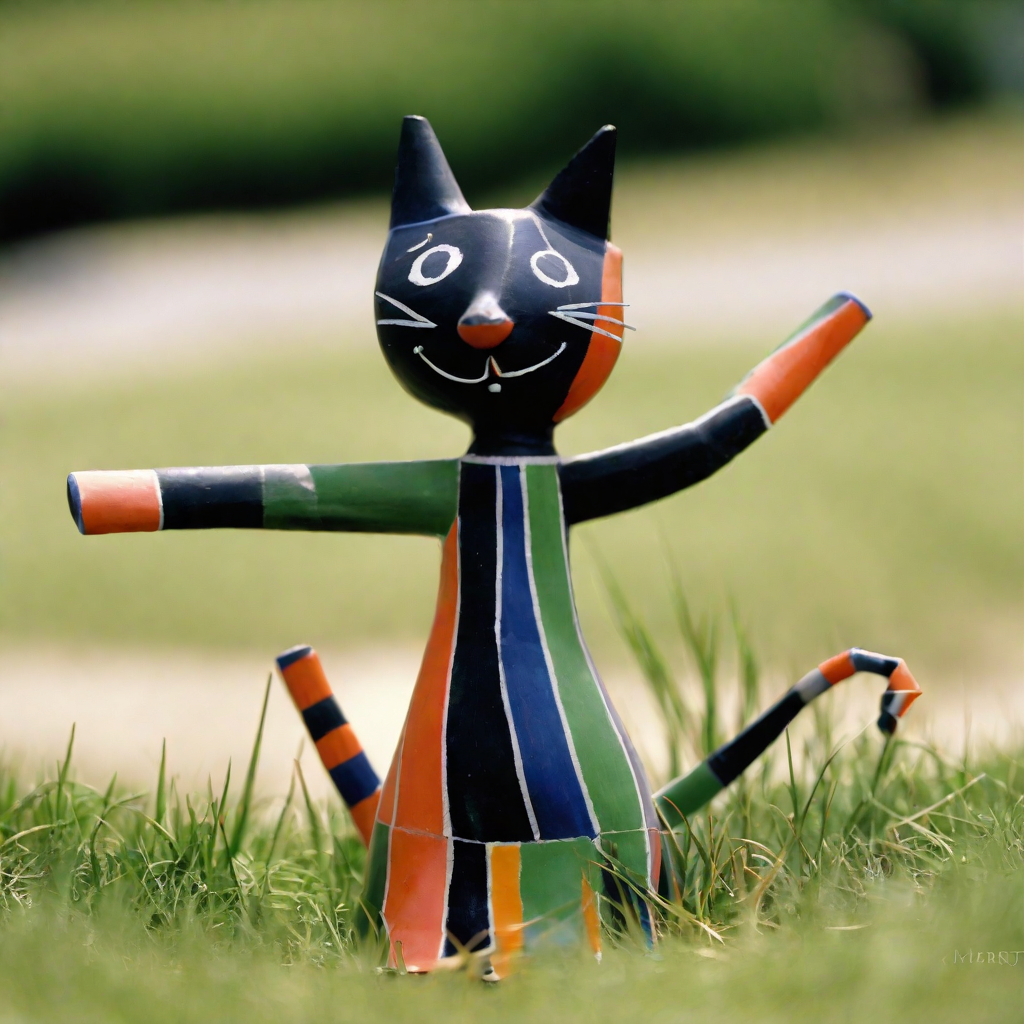

In [18]:
from IPython.display import Image
Image(filename='output.png')